# Movie lens data engineering

In [1]:
MOVIE_LENS_DATA_PATH = './data/ml-25m/'
!ls $MOVIE_LENS_DATA_PATH

README.txt	   genome-tags.csv  movies.csv	 tags.csv
genome-scores.csv  links.csv	    ratings.csv


In [2]:
import pandas as pd
import numpy as np

In [3]:
movies = pd.read_csv(MOVIE_LENS_DATA_PATH+"movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv(MOVIE_LENS_DATA_PATH+"ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
links = pd.read_csv(MOVIE_LENS_DATA_PATH+"links.csv", dtype={'imdbId':str, 'tmdbId': str})
links.head()

,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


In [6]:
numeric_features = []
cat_features = []

## Extract movie statistics


### Movies ave rating & numbers of ratings

In [7]:
movies_num_ratings = pd.DataFrame(ratings.groupby('movieId').agg({'userId': ['count'],
                                                                  'rating': ['mean']}))

In [8]:
movies_num_ratings.columns = ["_".join(x) for x in movies_num_ratings.columns.ravel()]

In [9]:
movies_num_ratings.head()

,userId_count,rating_mean
movieId,,
1,57309,3.893708
2,24228,3.251527
3,11804,3.142028
4,2523,2.853547
5,11714,3.058434


In [10]:
movies = movies.join(movies_num_ratings, on = 'movieId')

In [11]:
movies.head()

,movieId,title,genres,userId_count,rating_mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434


In [12]:
numeric_features += ['userId_count', 'rating_mean']

## Extract movie year

In [13]:
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)

movies['year_cat'] = movies['year']

In [14]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0


In [15]:
numeric_features += ['year']
cat_features += ['year_cat'] # encode year as both numeric and cat?

## Movies genres

In [16]:
from tqdm import tqdm

for i, row in tqdm(movies.iterrows(), total=len(movies)):
    try:
        row_genres = row['genres'].split('|')
        for g in row_genres:
            movies.at[i, g] = 1
    except:
        pass

100%|██████████| 62423/62423 [00:04<00:00, 14991.51it/s]


In [17]:
genres = set()

In [18]:
for g in movies['genres']:
    genres = genres.union(set(g.split('|')))

In [19]:
genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [20]:
len(genres)

20

In [21]:
cat_features += ['genres']

## Tags & genres: using TF-IDF and SVD

In [22]:
tags = pd.read_csv(MOVIE_LENS_DATA_PATH+"tags.csv")
# create a mixed dataframe of movies title, genres 
# and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Adventure,Animation,Children,...,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed),userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,791.0,Owned,1.515175e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1048.0,imdb top 250,1.172144e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1361.0,Pixar,1.216146e+09


In [23]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                             lambda x: "%s" % ' '.join(x)))


In [24]:
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x.split('|')))

In [25]:
movies_meta = pd.merge(movies, mixed, on='movieId', how='left')
movies_meta['metadata'] = movies_meta[['genres', 'tag']].apply(
                             lambda x: ' '.join(x), axis = 1)
movies_meta[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy Ow...
1,2,Jumanji (1995),Adventure Children Fantasy Robin Williams time...
2,3,Grumpier Old Men (1995),Comedy Romance funny best friend duringcredits...


### TF-IDF vectorizer

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_meta['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies_meta['movieId'].tolist())
print(tfidf_df.shape)

(62423, 35768)


In [27]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,35758,35759,35760,35761,35762,35763,35764,35765,35766,35767
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
len(tfidf.vocabulary_)

35768

In [29]:
!mkdir ./assets

In [30]:
import pickle

with open('./assets/movie-lens-tf-idf.pkl', 'wb') as f:
    pickle.dump({"tfidf": tfidf}, f)

#### TF-IDF Transform new movie

In [31]:
new_movie_feat = tfidf.transform(['cartoon'])

In [32]:
new_movie_feat

<1x35768 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

### SVD on content

In [33]:
NUM_LATENT_FACTOR = 128

# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=NUM_LATENT_FACTOR)
latent_matrix = svd.fit_transform(tfidf_df)
 
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()


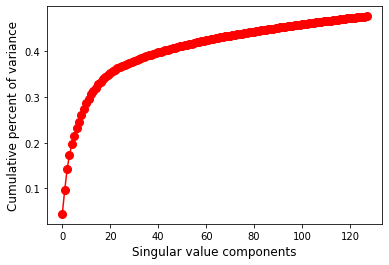

In [34]:
import matplotlib.pyplot as plt
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [35]:
latent_matrix_1_df = pd.DataFrame(latent_matrix,
                                  index=movies_meta['movieId'].tolist())

In [36]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
1,0.040733,0.000288,0.051061,0.002787,0.028925,0.011605,-0.090231,0.293034,-0.019821,0.198646,...,-0.019055,-0.022449,-0.017143,-0.008737,-0.010099,-0.006274,0.029068,0.013725,-0.002295,0.001604
2,0.013167,0.000391,0.005223,0.001949,0.024602,0.013538,-0.019610,0.082290,-0.009335,0.016648,...,-0.003519,-0.007143,-0.002481,-0.014160,-0.006464,0.005452,0.010710,-0.007890,0.003952,0.003624
3,0.025699,-0.000123,0.028008,-0.000756,0.000757,0.033766,0.006393,-0.000743,-0.004234,0.001167,...,-0.004957,-0.012409,-0.002101,-0.033175,-0.018218,-0.030952,0.034621,-0.015034,-0.011096,-0.000550
4,0.099710,-0.001300,0.028950,-0.003484,-0.008644,0.069895,0.014720,-0.002508,-0.008597,0.004705,...,-0.030901,-0.005265,0.013356,-0.031088,0.009554,0.004346,0.058679,0.000794,0.010145,-0.036085
5,0.059480,-0.000102,0.083627,-0.001704,0.003635,-0.008453,-0.001699,0.017315,0.003003,0.003468,...,-0.009724,0.004267,-0.012850,-0.066092,-0.015030,-0.009652,0.028920,-0.037854,0.051414,-0.041663


In [37]:
latent_matrix_1_df.set_axis(['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)], axis='columns', inplace=True)
latent_matrix_1_df.columns

Index(['SVD_latent_0', 'SVD_latent_1', 'SVD_latent_2', 'SVD_latent_3',
       'SVD_latent_4', 'SVD_latent_5', 'SVD_latent_6', 'SVD_latent_7',
       'SVD_latent_8', 'SVD_latent_9',
       ...
       'SVD_latent_118', 'SVD_latent_119', 'SVD_latent_120', 'SVD_latent_121',
       'SVD_latent_122', 'SVD_latent_123', 'SVD_latent_124', 'SVD_latent_125',
       'SVD_latent_126', 'SVD_latent_127'],
      dtype='object', length=128)

In [38]:
latent_matrix_1_df['movieId'] = latent_matrix_1_df.index

In [39]:
latent_matrix_1_df.head()

,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,SVD_latent_6,SVD_latent_7,SVD_latent_8,SVD_latent_9,...,SVD_latent_119,SVD_latent_120,SVD_latent_121,SVD_latent_122,SVD_latent_123,SVD_latent_124,SVD_latent_125,SVD_latent_126,SVD_latent_127,movieId
1,0.040733,0.000288,0.051061,0.002787,0.028925,0.011605,-0.090231,0.293034,-0.019821,0.198646,...,-0.022449,-0.017143,-0.008737,-0.010099,-0.006274,0.029068,0.013725,-0.002295,0.001604,1
2,0.013167,0.000391,0.005223,0.001949,0.024602,0.013538,-0.019610,0.082290,-0.009335,0.016648,...,-0.007143,-0.002481,-0.014160,-0.006464,0.005452,0.010710,-0.007890,0.003952,0.003624,2
3,0.025699,-0.000123,0.028008,-0.000756,0.000757,0.033766,0.006393,-0.000743,-0.004234,0.001167,...,-0.012409,-0.002101,-0.033175,-0.018218,-0.030952,0.034621,-0.015034,-0.011096,-0.000550,3
4,0.099710,-0.001300,0.028950,-0.003484,-0.008644,0.069895,0.014720,-0.002508,-0.008597,0.004705,...,-0.005265,0.013356,-0.031088,0.009554,0.004346,0.058679,0.000794,0.010145,-0.036085,4
5,0.059480,-0.000102,0.083627,-0.001704,0.003635,-0.008453,-0.001699,0.017315,0.003003,0.003468,...,0.004267,-0.012850,-0.066092,-0.015030,-0.009652,0.028920,-0.037854,0.051414,-0.041663,5


In [40]:
movies = movies.merge(latent_matrix_1_df, on='movieId', how='left')

In [41]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Adventure,Animation,Children,...,SVD_latent_118,SVD_latent_119,SVD_latent_120,SVD_latent_121,SVD_latent_122,SVD_latent_123,SVD_latent_124,SVD_latent_125,SVD_latent_126,SVD_latent_127
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1.0,1.0,1.0,...,-0.019055,-0.022449,-0.017143,-0.008737,-0.010099,-0.006274,0.029068,0.013725,-0.002295,0.001604
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1.0,NaN,1.0,...,-0.003519,-0.007143,-0.002481,-0.014160,-0.006464,0.005452,0.010710,-0.007890,0.003952,0.003624
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,NaN,NaN,NaN,...,-0.004957,-0.012409,-0.002101,-0.033175,-0.018218,-0.030952,0.034621,-0.015034,-0.011096,-0.000550
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,NaN,NaN,NaN,...,-0.030901,-0.005265,0.013356,-0.031088,0.009554,0.004346,0.058679,0.000794,0.010145,-0.036085
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,NaN,NaN,NaN,...,-0.009724,0.004267,-0.012850,-0.066092,-0.015030,-0.009652,0.028920,-0.037854,0.051414,-0.041663


In [42]:
numeric_features += ['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)]

In [43]:
numeric_features

['userId_count',
 'rating_mean',
 'year',
 'SVD_latent_0',
 'SVD_latent_1',
 'SVD_latent_2',
 'SVD_latent_3',
 'SVD_latent_4',
 'SVD_latent_5',
 'SVD_latent_6',
 'SVD_latent_7',
 'SVD_latent_8',
 'SVD_latent_9',
 'SVD_latent_10',
 'SVD_latent_11',
 'SVD_latent_12',
 'SVD_latent_13',
 'SVD_latent_14',
 'SVD_latent_15',
 'SVD_latent_16',
 'SVD_latent_17',
 'SVD_latent_18',
 'SVD_latent_19',
 'SVD_latent_20',
 'SVD_latent_21',
 'SVD_latent_22',
 'SVD_latent_23',
 'SVD_latent_24',
 'SVD_latent_25',
 'SVD_latent_26',
 'SVD_latent_27',
 'SVD_latent_28',
 'SVD_latent_29',
 'SVD_latent_30',
 'SVD_latent_31',
 'SVD_latent_32',
 'SVD_latent_33',
 'SVD_latent_34',
 'SVD_latent_35',
 'SVD_latent_36',
 'SVD_latent_37',
 'SVD_latent_38',
 'SVD_latent_39',
 'SVD_latent_40',
 'SVD_latent_41',
 'SVD_latent_42',
 'SVD_latent_43',
 'SVD_latent_44',
 'SVD_latent_45',
 'SVD_latent_46',
 'SVD_latent_47',
 'SVD_latent_48',
 'SVD_latent_49',
 'SVD_latent_50',
 'SVD_latent_51',
 'SVD_latent_52',
 'SVD_latent_5

#### SVD transform new movie

In [44]:
latent_matrix = svd.transform(new_movie_feat)

In [45]:
latent_matrix.shape

(1, 128)

In [46]:
with open('./assets/svd.pkl', 'wb') as f:
    pickle.dump({"svd": svd}, f)

##  Popularity score

https://www.kaggle.com/rounakbanik/movie-recommender-systems?

Weighted Rating (WR) = (v/(v+m).R)+(m/(v+m).C)

where,

    v is the number of votes for the movie
    m is the minimum votes required to be listed in the chart
    R is the average rating of the movie
    C is the mean vote across the whole report


In [47]:
C = ratings['rating'].mean()
C

3.533854451353085

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [48]:
m = movies_num_ratings['userId_count'].quantile(0.95)
m

1503.3999999999942



Therefore, to qualify to be considered for the chart, a movie has to have at least 1503 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10. 2274 Movies qualify to be on our chart.


In [49]:
qualified = movies[movies['userId_count'] >= m]

In [50]:
qualified.shape

(2953, 155)

In [51]:
def weighted_rating(x):
    v = x['userId_count']
    R = x['rating_mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [52]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

<ipython-input-52-a4cac61d7166>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['wr'] = qualified.apply(weighted_rating, axis=1)


In [53]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [54]:
qualified.head(5)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Adventure,Animation,Children,...,SVD_latent_119,SVD_latent_120,SVD_latent_121,SVD_latent_122,SVD_latent_123,SVD_latent_124,SVD_latent_125,SVD_latent_126,SVD_latent_127,wr
314,318,"Shawshank Redemption, The (1994)",Crime Drama,81482.0,4.413576,1994.0,1994.0,NaN,NaN,NaN,...,0.025920,0.030796,0.028525,-0.027145,0.017096,-0.019043,0.019874,0.032946,-0.000728,4.397639
840,858,"Godfather, The (1972)",Crime Drama,52498.0,4.324336,1972.0,1972.0,NaN,NaN,NaN,...,0.024581,0.021631,-0.013779,0.007075,0.051917,-0.072988,0.086586,-0.023442,0.051104,4.302329
49,50,"Usual Suspects, The (1995)",Crime Mystery Thriller,55366.0,4.284353,1995.0,1995.0,NaN,NaN,NaN,...,0.065105,0.037049,0.021507,-0.010153,0.007335,-0.056711,0.013939,-0.000463,0.041340,4.264513
1190,1221,"Godfather: Part II, The (1974)",Crime Drama,34188.0,4.261759,1974.0,1974.0,NaN,NaN,NaN,...,0.018373,0.021855,-0.026541,0.005946,0.035619,-0.070620,0.076672,-0.020373,0.063375,4.231098
522,527,Schindler's List (1993),Drama War,60411.0,4.247579,1993.0,1993.0,NaN,NaN,NaN,...,0.009005,-0.015035,0.034175,0.010885,0.003422,0.001237,0.005436,-0.017890,-0.014467,4.230248


In [55]:
cat_features += [g for g in genres]

In [56]:
cat_features

['year_cat',
 'genres',
 'Crime',
 'Thriller',
 'Animation',
 'Children',
 'Film-Noir',
 'Drama',
 'Romance',
 'Comedy',
 'Sci-Fi',
 'War',
 'Documentary',
 '(no genres listed)',
 'Mystery',
 'IMAX',
 'Adventure',
 'Horror',
 'Action',
 'Musical',
 'Fantasy',
 'Western']

### Popularity score per genre

In [57]:
def build_chart(genre, percentile=0.85):
    df = movies[movies[genre] == 1] #filter out genre
    
    C = ratings['rating'].mean()
    m = movies_num_ratings['userId_count'].quantile(percentile)
    
    qualified = df[df['userId_count'] >= m]
    qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
    
    qualified = qualified.sort_values('%s_wr'%genre, ascending=False).head(250)
    qualified.reset_index(inplace=True, drop=True)
    qualified['%s_rank'%genre] = qualified.index
    
    return qualified

In [58]:
for genre in tqdm(genres):
     chart = build_chart(genre)
     movies = movies.merge(chart[["movieId", "%s_wr"%genre, "%s_rank"%genre]], on='movieId', how='left')

    

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-57-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
  5%|▌         | 1/20 [00:00<00:03,  4.87it/s]<ipython-input-57-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
 10%|█         | 2/20 [00:00<00:04,  4.12it/s]<ipython-input-57-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be 

In [59]:
movies.fillna(0, inplace=True)

In [60]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Adventure,Animation,Children,...,Horror_wr,Horror_rank,Action_wr,Action_rank,Musical_wr,Musical_rank,Fantasy_wr,Fantasy_rank,Western_wr,Western_rank
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.884509,19.0,0.0,0.0
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [61]:
movies.shape

(62423, 195)

In [62]:
numeric_features += ["%s_wr"%g for g in genres]
numeric_features += ["%s_rank"%g for g in genres]

In [63]:
#numeric_features
cat_features = ['userId_factor',
 'movieId_factor','year_cat',
 'genres',
 '(no genres listed)',
 'Thriller',
 'Documentary',
 'Animation',
 'Horror',
 'Musical',
 'Film-Noir',
 'Romance',
 'Action',
 'IMAX',
 'Western',
 'Crime',
 'Adventure',
 'Comedy',
 'Fantasy',
 'Mystery',
 'Drama',
 'Children',
 'Sci-Fi',
 'War',
 ]

In [64]:
cat_features

['userId_factor',
 'movieId_factor',
 'year_cat',
 'genres',
 '(no genres listed)',
 'Thriller',
 'Documentary',
 'Animation',
 'Horror',
 'Musical',
 'Film-Noir',
 'Romance',
 'Action',
 'IMAX',
 'Western',
 'Crime',
 'Adventure',
 'Comedy',
 'Fantasy',
 'Mystery',
 'Drama',
 'Children',
 'Sci-Fi',
 'War']

In [65]:
with open('./assets/features.pkl', 'wb') as f:
    pickle.dump({"numeric_features": numeric_features, 'cat_features': cat_features }, f)


In [66]:
print(len(cat_features))
print(len(numeric_features))

24
171


In [67]:
# normalize
normalize_feats = [x for x in numeric_features if not x.startswith('SVD')]
for col in normalize_feats:    
    movies[col] = (movies[col] - movies[col].mean())/movies[col].std(ddof=0)


In [68]:
# factorize, except for userID & movieID
cat_mappings = {}
for f in cat_features[2:]:
    movies[f], cat_mappings[f]  = pd.factorize(movies[f])

In [69]:
len(cat_mappings)

22

# Using IMDB ID

In [70]:
movies = movies.merge(links, on='movieId', how='left')

In [71]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Adventure,Animation,Children,...,Action_wr,Action_rank,Musical_wr,Musical_rank,Fantasy_wr,Fantasy_rank,Western_wr,Western_rank,imdbId,tmdbId
0,1,Toy Story (1995),0,23.595563,0.988274,0.098469,0,0,0,0,...,-0.063366,-0.054833,-0.063386,-0.054833,16.735814,2.034624,-0.052321,-0.045307,0114709,862
1,2,Jumanji (1995),1,9.879427,0.346202,0.098469,0,0,1,0,...,-0.063366,-0.054833,-0.063386,-0.054833,-0.063366,-0.054833,-0.052321,-0.045307,0113497,8844
2,3,Grumpier Old Men (1995),2,4.728153,0.236722,0.098469,0,1,1,1,...,-0.063366,-0.054833,-0.063386,-0.054833,-0.063366,-0.054833,-0.052321,-0.045307,0113228,15602
3,4,Waiting to Exhale (1995),3,0.880039,-0.051710,0.098469,0,1,1,1,...,-0.063366,-0.054833,-0.063386,-0.054833,-0.063366,-0.054833,-0.052321,-0.045307,0114885,31357
4,5,Father of the Bride Part II (1995),4,4.690837,0.153142,0.098469,0,1,1,1,...,-0.063366,-0.054833,-0.063386,-0.054833,-0.063366,-0.054833,-0.052321,-0.045307,0113041,11862


In [72]:
movies.to_csv(MOVIE_LENS_DATA_PATH+"movies_preprocessed_v4.csv", index=False)

In [73]:
movies.shape

(62423, 197)

# Rating data

In [74]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [75]:
ratings['movieId_factor'], movies_mappings = pd.factorize(ratings['movieId'])

In [76]:
movies_mappings

Int64Index([   296,    306,    307,    665,    899,   1088,   1175,   1217,
              1237,   1250,
            ...
            200178, 200182, 200186, 200188, 200190, 200192, 200194, 139970,
            200726, 200728],
           dtype='int64', length=59047)

In [77]:
ratings['userId_factor'], user_mappings = pd.factorize(ratings['userId'])

In [78]:
user_mappings

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            162532, 162533, 162534, 162535, 162536, 162537, 162538, 162539,
            162540, 162541],
           dtype='int64', length=162541)

In [79]:
ratings.head()

,userId,movieId,rating,timestamp,movieId_factor,userId_factor
0,1,296,5.0,1147880044,0,0
1,1,306,3.5,1147868817,1,0
2,1,307,5.0,1147868828,2,0
3,1,665,5.0,1147878820,3,0
4,1,899,3.5,1147868510,4,0


In [80]:
cat_mappings.update({'movieId_factor':movies_mappings, 'userId_factor': user_mappings})

In [81]:
with open('./assets/cat_mappings.pkl', 'wb') as f:
    pickle.dump({"cat_mappings": cat_mappings}, f)

# Divide into train and test

In [82]:
ratings = ratings.merge(links, how='left', on='movieId')
ratings.head()

,userId,movieId,rating,timestamp,movieId_factor,userId_factor,imdbId,tmdbId
0,1,296,5.0,1147880044,0,0,0110912,680
1,1,306,3.5,1147868817,1,0,0111495,110
2,1,307,5.0,1147868828,2,0,0108394,108
3,1,665,5.0,1147878820,3,0,0114787,11902
4,1,899,3.5,1147868510,4,0,0045152,872


In [83]:
MIN_RATINGS = 20
USER_COLUMN = 'userId'
ITEM_COLUMN = 'movieId'

grouped = ratings.groupby(USER_COLUMN)

In [84]:
df = ratings

# Need to sort before popping to get last item
df.sort_values(by='timestamp', inplace=True)

# clean up data
del df['rating'], df['timestamp']
df = df.drop_duplicates() # assuming it keeps order

# now we have filtered and sorted by time data, we can split test data out
grouped_sorted = df.groupby(USER_COLUMN, group_keys=False)
test_data = grouped_sorted.tail(1).sort_values(by=USER_COLUMN)
# need to pop for each group
train_data = grouped_sorted.apply(lambda x: x.iloc[:-1])

In [85]:
del train_data['imdbId'], train_data['tmdbId'], train_data['userId']
del test_data['imdbId'], test_data['tmdbId'], test_data['userId']

In [86]:
train_data.head()

,movieId,movieId_factor,userId_factor
36,5952,36,0
13,2012,13,0
12,2011,12,0
11,1653,11,0
9,1250,9,0


In [87]:
test_data.head()

,movieId,movieId_factor,userId_factor
48,7361,48,0
148,2150,147,1
307,1732,283,2
919,1136,101,3
1226,1016,978,4


In [88]:
train_data.to_csv(MOVIE_LENS_DATA_PATH+"train.csv")
test_data.to_csv(MOVIE_LENS_DATA_PATH+"test.csv")

In [89]:
len(movies_mappings)

59047

In [90]:
len(user_mappings)

162541

In [91]:
%%writefile model_size.json
{
    "_c54": 162541,
    "_c55": 59047,
    "_c56": 136,
    "_c57": 1639,
    "_c58": 2,
    "_c59": 2,
    "_c60": 2,
    "_c61": 2,
    "_c62": 2,
    "_c63": 2,
    "_c64": 2,
    "_c65": 2,
    "_c66": 2,
    "_c67": 2,
    "_c68": 2,
    "_c69": 2,
    "_c70": 2,
    "_c71": 2,
    "_c72": 2,
    "_c73": 2,
    "_c74": 2,
    "_c75": 2,
    "_c76": 2,
    "_c77": 2
}

Writing model_size.json


!python ./dlrm/scripts/main_movie_lens.py \
--mode train \
--dataset /data/dlrm/binary_dataset/ \
--num_numerical_features 1 \
--base_device cuda \
--lr 0.1 \
--embedding_type joint \
--epochs 10 \
--batch_size=8192 \
--save_checkpoint_path ./movie_lens_dlrm

# Batching data test

In [92]:
steps_per_epoch = len(ratings)/16384
batch_indices = np.array_split(ratings.index, steps_per_epoch)

In [94]:
batch_data = ratings.ix[batch_indices[0]].copy()

AttributeError: 'DataFrame' object has no attribute 'ix'

In [ ]:
batch_data_neg = batch_data.copy()

In [ ]:
all_movies_id = movies['movieId']

In [ ]:
all_movies_id.head()

In [ ]:
batch_data_neg['movieId'] = all_movies_id.sample(n=batch_data_neg.shape[0]).values

In [ ]:
batch_data = pd.concat([batch_data, batch_data_neg])

In [ ]:
batch_data.shape

In [ ]:
batch_data.dtypes

In [ ]:
batch_data = batch_data.merge(movies, on='movieId', how='left')

In [ ]:
numerical_data = batch_data[numeric_features]


In [ ]:
cat_data = batch_data[cat_features]

In [ ]:
cat_data.shape

In [ ]:
numerical_data.shape

In [ ]:
# negative data
